**Importing the Required Libaries**

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from matplotlib import style
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Getting the Data
1. Authors have manulally collected the data and labelled them and verified from Office of West Java language Hall
![Example Data](labelled_data.PNG)
2. For this example Data is taken from [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)

In [2]:
df = pd.read_csv("data/tweet_data.csv")
df.shape

(31962, 3)

In [3]:
hate_df = df[df['label']==1]
non_hate_df = df[df['label']==0]

In [4]:
# printing first Hate  data
print(hate_df['tweet'].iloc[0],"\n")
print(hate_df['tweet'].iloc[1],"\n")
print(hate_df['tweet'].iloc[2],"\n")
print(hate_df['tweet'].iloc[3],"\n")
print(hate_df['tweet'].iloc[6],"\n")

@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot   

no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins 

retweet if you agree!  

@user @user lumpy says i am a . prove it lumpy. 

ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness   



In [5]:
# printing first few data
print(non_hate_df['tweet'].iloc[0],"\n")
print(non_hate_df['tweet'].iloc[1],"\n")
print(non_hate_df['tweet'].iloc[2],"\n")
print(non_hate_df['tweet'].iloc[3],"\n")
print(non_hate_df['tweet'].iloc[10],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 

  bihday your majesty 

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   

 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex 



## Pre-Processing

### Case Folding

* Convert all the words in the sentence to lowercase letters. 

### Tokenizing
* At this stage, symbols like `?`,`""`,`@` etc are removed
* Text is seperated into sequentials token

### Filtering (Stop Words Removal)
* Removing the Words that are not necessary for next step

In [6]:
print(stop_words)

{'no', 'by', 'shouldn', 'own', 'before', 'his', 'hers', 'through', 'don', 'himself', 'shan', 'do', 'them', 'and', 'wouldn', 'isn', 'o', 'how', "you'll", 've', 'been', 'above', 'we', 'should', 'the', 're', 'hasn', 'haven', 'our', 'can', "wasn't", "mightn't", "that'll", 'won', 'were', 'just', 'each', 'her', 'between', 'yourselves', 'ain', 'until', "you'd", 'd', 'was', 'your', 'm', 'doing', 'so', 'up', 'herself', "couldn't", 'in', "isn't", 'who', 'did', 'after', "weren't", 'all', 'off', 'i', "won't", 'where', 'does', 'such', 'now', 'into', 'aren', 'under', 'an', "should've", 'y', 'below', "didn't", 'with', 'any', 'very', 'if', 'further', 'when', "aren't", 'me', 'myself', 'a', 'what', "she's", 'having', 'ours', 'am', 'its', 'against', 'over', 'because', "mustn't", 'themselves', 'to', "hasn't", 'him', 'again', 'about', 'is', 'which', 't', 's', 'during', 'down', 'had', "shan't", 'mightn', "needn't", 'they', 'then', 'these', 'didn', 'wasn', 'it', 'has', 'too', "you've", 'why', 'yours', "it's"

### Stemming

* Converting the word in same form. For example `running` is converted to `run`

In [7]:
def data_processing(tweet):
    # Case Folding 
    tweet = tweet.lower()
    # Tokenizing
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet_tokens = word_tokenize(tweet)
    # Filtering
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [8]:
df['tweet'] = df['tweet'].apply(data_processing)
# printing the data to see the effect of preprocessing
print(df['tweet'].iloc[0],"\n")
print(df['tweet'].iloc[1],"\n")
print(df['tweet'].iloc[2],"\n")
print(df['tweet'].iloc[3],"\n")
print(df['tweet'].iloc[6],"\n")

user father dysfunctional selfish drags kids dysfunction run 

user user thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked 

bihday majesty 

model love u take u time ur 

user camping tomorrow user user user user user user user dannyâ 



In [9]:
stemmer = PorterStemmer()
def stemming(data):
    tweet = [stemmer.stem(word) for word in data]
    return data

In [10]:
df['tweet'] = df['tweet'].apply(lambda x: stemming(x))
# printing the data to see the effect of preprocessing
print(df['tweet'].iloc[0],"\n")
print(df['tweet'].iloc[1],"\n")
print(df['tweet'].iloc[2],"\n")
print(df['tweet'].iloc[3],"\n")
print(df['tweet'].iloc[6],"\n")

user father dysfunctional selfish drags kids dysfunction run 

user user thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked 

bihday majesty 

model love u take u time ur 

user camping tomorrow user user user user user user user dannyâ 



## TF-IDF Calculation

Figure below shows the process for calculating TF-IDF
![TF-IDF Calculation Process](tf_idf_calc_process.PNG)

1. Term Frequency(TF):

Number of occurrences of a term (t) in each tweet

2. Document Frequency(DF):

DF measures the importance of documents in a whole set of the corpus. This is very similar to TF but the only difference is that TF is the frequency counter for a term t in document d, whereas DF is the count of occurrences of term t in the document set N

3. Inverse Document Frequency(IDF)

IDF is the inverse of the document frequency which measures the informativeness of term t. 

$idf(t) = N/df$
Few Problems with above Formula:
* when we have a large corpus size say N=10000, the IDF value explodes. So to dampen the effect we take the log of IDF.
* If df=0 then value is undefined
To resolve the problem log is used

$idf(t) = log(N/(df + 1))$

4. Term Frequency — Inverse Document Frequency(TF-IDF)

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF)

$TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)$

In [11]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(df['tweet'])
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 208579

First 20 features: 
['0000001' '0000001 polluting' '00027' '00027 photooftheday' '001' '0035'
 '00h30' '01' '01 4995' '01 7900' '01 blog' '01 croatia' '01 may'
 '01 shopalyssas' '0115' '0115 8599968' '0161' '0161 manny' '019'
 '019 previous']


In [12]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(df['tweet'])
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 380305

First 20 features: 
['0000001' '0000001 polluting' '0000001 polluting niger' '00027'
 '00027 photooftheday' '00027 photooftheday music' '001' '0035' '00h30'
 '01' '01 4995' '01 4995 rustic' '01 7900' '01 7900 shopalyssas' '01 blog'
 '01 blog silver' '01 croatia' '01 croatia happy' '01 may' '01 may actual']


<AxesSubplot:>

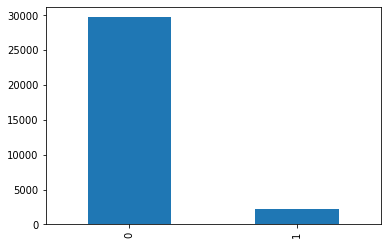

In [13]:
df['label'].value_counts().plot(kind='bar')

## Train Test Split

Splitting the Data into Training and Testing Set. In the paper, the best result was obtained in 90-10 split so suing the same.

In [14]:
X = df['tweet']
y = df['label']
X = vect.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Model Building


Given a data(X,Y), X being a matrix of values with m examples and n features and Y being a vector with m examples. The objective is to train the model to predict which class the future values belong to. Primarily, we create a weight matrix with random initialization. Then we multiply it by features.

![Linear Equation](linear.PNG)

![Logit Function](logit.PNG)


![Weight Update](weight_update.PNG)

In [15]:
logreg = LogisticRegression(multi_class="multinomial")
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

Test accuarcy: 95.12%


## Model Evaluation

### Confusion Matrix

A confusion matrix is a tabular summary of the number of correct and incorrect predictions made by a classifier. It is used to measure the performance of a classification model. It can be used to evaluate the performance of a classification model through the calculation of performance metrics like accuracy, precision, recall, and F1-score.

![Confusion Matrxi](confusion_matrix.png)


#### True Positive (TP)
The model predicted positive value(1) and the actual value is also positive(1). In our example, we predicted that the text is hateful prediction is also hateful.
#### True Negative (TN)
The model predicted negative value(0) and the actual value is also negative (0). In our example, we predcited that the text is not hateful and prediction is also not hateful
#### False Positive (FP)
There are negative cases where the we incorrectly predicted postitive. We predicted the text is hatfeul but they actually are not hateful. This is also called **Type-1 Error**.
#### False Negative (FN)
There are postive cases where the we incorrectly predicted negative. We predicted the text is not hateful but they actually are hateful. This is also called **Type-2 Error**.

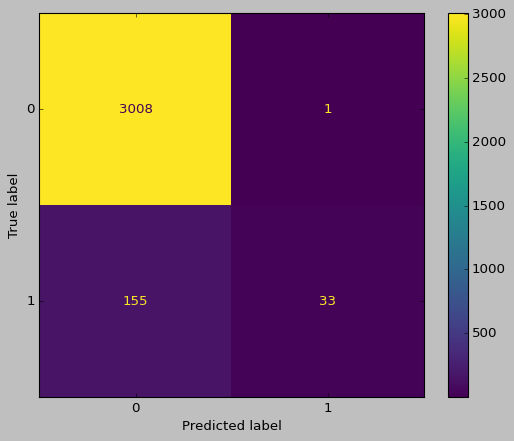

In [16]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

### Precision Recall,F-1 Score and Accuracy

![Calculation Formula](metrices.JPG)

In [17]:
print(classification_report(y_test, logreg_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3009
           1       0.97      0.18      0.30       188

    accuracy                           0.95      3197
   macro avg       0.96      0.59      0.64      3197
weighted avg       0.95      0.95      0.93      3197

